In [4]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#configuring output location
from pathlib import Path
OUTPUT_DIR = Path("/content/drive/MyDrive/MSML612 Project/outputs")
OUTPUT_DIR.mkdir(parents = True, exist_ok = True)

#importing necessary libraries
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#matplotlib plots
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 12

#printing the output directory path and number of files in that location
print("Looking for predictions in:", OUTPUT_DIR)
print("Found:", len(glob.glob(str(OUTPUT_DIR / "predictions_*.csv"))), "files")

Mounted at /content/drive
Looking for predictions in: /content/drive/MyDrive/MSML612 Project/outputs
Found: 6 files


In [5]:
#loading predictions
def load_all_predictions(output_dir: Path):
    files = glob.glob(str(output_dir / "predictions_*.csv"))
    dfs = []
    for f in files:
        df = pd.read_csv(f, parse_dates = ["date"], infer_datetime_format = True)
        #identifying the required columns for evaluation
        req = {"date", "split", "y_true", "y_pred", "model"}
        missing = req - set(df.columns)
        if missing:
            raise ValueError(f"{f} missing columns: {missing}")
        if "horizon" not in df.columns:
            df["horizon"] = 1
        dfs.append(df)
    out = pd.concat(dfs, ignore_index = True)
    #clean the fields
    out["split"] = out["split"].astype(str)
    out["model"] = out["model"].astype(str)
    out["horizon"] = out["horizon"].astype(int)
    out = out.sort_values(["model","split","horizon","date"]).reset_index(drop = True)
    return out

pred = load_all_predictions(OUTPUT_DIR)
pred.head()

/tmp/ipython-input-2893359119.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(f, parse_dates = ["date"], infer_datetime_format = True)
/tmp/ipython-input-2893359119.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(f, parse_dates = ["date"], infer_datetime_format = True)
/tmp/ipython-input-2893359119.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datet

,date,split,y_true,y_pred,horizon,model
0,2025-04-01,test,4924.0,5105.571895,1,FeatureBase_LassoCV
1,2025-04-01,test,4924.0,5105.571895,1,FeatureBase_LassoCV
2,2025-04-02,test,4865.0,4650.615557,1,FeatureBase_LassoCV
3,2025-04-02,test,4865.0,4650.615557,1,FeatureBase_LassoCV
4,2025-04-03,test,4433.0,4061.226453,1,FeatureBase_LassoCV


In [6]:
#mean absolute error
def mae(y, p):
    y = np.asarray(y, float); p = np.asarray(p, float)
    return np.mean(np.abs(y - p))

#root mean squared error
def rmse(y, p):
    y = np.asarray(y, float); p = np.asarray(p, float)
    return np.sqrt(np.mean((y - p) ** 2))

#mean absolute percentage error
def mape(y, p, eps = 1e-8):
    y = np.asarray(y, float); p = np.asarray(p, float)
    mask = np.abs(y) > eps
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y[mask] - p[mask]) / y[mask])) * 100.0

#symmetric mean absolute percentage error
def smape(y, p, eps= 1e-8):
    y = np.asarray(y, float); p = np.asarray(p, float)
    denom = (np.abs(y) + np.abs(p) + eps)
    return np.mean(200.0 * np.abs(y - p) / denom)

#weighted absolute percentage error
def wape(y, p, eps = 1e-8):
    y = np.asarray(y, float); p = np.asarray(p, float)
    denom = np.sum(np.abs(y)) + eps
    return np.sum(np.abs(y - p)) / denom * 100.0

METRICS = {
    "MAE": mae,
    "RMSE": rmse,
    "MAPE_%": mape,
    "sMAPE_%": smape,
    "WAPE_%": wape,
}

In [7]:
#summarizing all the metrics for the models
def summarize_metrics(df: pd.DataFrame, group_cols):
    rows = []
    for keys, g in df.groupby(group_cols):
        rec = dict(zip(group_cols, keys if isinstance(keys, tuple) else (keys,)))
        for name, fn in METRICS.items():
            rec[name] = fn(g["y_true"].values, g["y_pred"].values)
        rec["n"] = len(g)
        rows.append(rec)
    return pd.DataFrame(rows)

#leaderboard 1 - overall models
print("Leaderboard 1: Top Models")
lb_overall = summarize_metrics(pred, ["model"]).sort_values(["RMSE","MAE"]).reset_index(drop = True)

#leaderboard 2: by split and model
print("Leaderboard 2: Top Models by Split")
lb_split = summarize_metrics(pred, ["split","model"]).sort_values(["split","RMSE","MAE"]).reset_index(drop = True)

#leaderboard 3 - by horizon, split and model
print("Leaderboard 3: Top Models by Split and Horizon")
lb_h = summarize_metrics(pred, ["horizon","split","model"]).sort_values(["horizon","split","RMSE","MAE"]).reset_index(drop = True)

display(lb_overall.head(20))
display(lb_split.head(40))
display(lb_h.head(60))

#saving each leaderbaord as a csv in OUTPUT_DIR
lb_overall.to_csv(OUTPUT_DIR / "metrics_leaderboard_overall.csv", index = False)
lb_split.to_csv(OUTPUT_DIR / "metrics_leaderboard_by_split.csv", index = False)
lb_h.to_csv(OUTPUT_DIR / "metrics_leaderboard_by_horizon.csv", index = False)
print("Saved leaderboards can be found in", OUTPUT_DIR)

Leaderboard 1: Top Models
Leaderboard 2: Top Models by Split
Leaderboard 3: Top Models by Split and Horizon


,model,MAE,RMSE,MAPE_%,sMAPE_%,WAPE_%,n
0,FeatureBase_RandomForest,661.792286,962.085264,202.645090,28.796966,20.323466,324
1,FeatureBase_LinearRegression,619.973026,969.426389,207.789215,28.480788,19.039208,324
2,FeatureBase_LassoCV,652.807689,985.850575,218.243639,28.888858,20.047552,324
3,TabTx_Daily,1399.181958,1687.174868,560.469130,59.094091,49.996776,1183
4,FeatureBase_SARIMAX,1486.681440,1887.185373,205.476614,62.766993,45.655595,324


,split,model,MAE,RMSE,MAPE_%,sMAPE_%,WAPE_%,n
0,test,FeatureBase_RandomForest,661.792286,962.085264,202.645090,28.796966,20.323466,324
1,test,FeatureBase_LinearRegression,619.973026,969.426389,207.789215,28.480788,19.039208,324
2,test,FeatureBase_LassoCV,652.807689,985.850575,218.243639,28.888858,20.047552,324
3,test,FeatureBase_SARIMAX,1486.681440,1887.185373,205.476614,62.766993,45.655595,324
4,val,TabTx_Daily,1399.181958,1687.174868,560.469130,59.094091,49.996776,1183


,horizon,split,model,MAE,RMSE,MAPE_%,sMAPE_%,WAPE_%,n
0,1,test,FeatureBase_LinearRegression,561.722777,913.690395,122.245897,28.278491,16.916719,108
1,1,test,FeatureBase_RandomForest,672.696442,916.719755,100.952923,28.574956,20.258777,108
2,1,test,FeatureBase_LassoCV,638.058911,930.002046,116.146006,31.340887,19.215641,108
3,1,test,FeatureBase_SARIMAX,1551.240624,1965.285336,192.470501,64.305076,46.716819,108
4,1,val,TabTx_Daily,1357.212579,1650.155587,505.677248,58.011337,48.445260,169
5,2,val,TabTx_Daily,1425.723212,1725.074660,560.498035,59.397865,50.926758,169
6,3,test,FeatureBase_LinearRegression,644.387412,953.838202,247.746485,28.869610,20.119874,108
7,3,test,FeatureBase_RandomForest,695.542459,1001.231341,253.209741,29.550217,21.717102,108
8,3,test,FeatureBase_LassoCV,709.532443,1006.348681,263.423839,30.135175,22.153914,108
9,3,test,FeatureBase_SARIMAX,1462.766386,1838.368950,206.171705,62.705060,45.672332,108


Saved leaderboards can be found in /content/drive/MyDrive/MSML612 Project/outputs


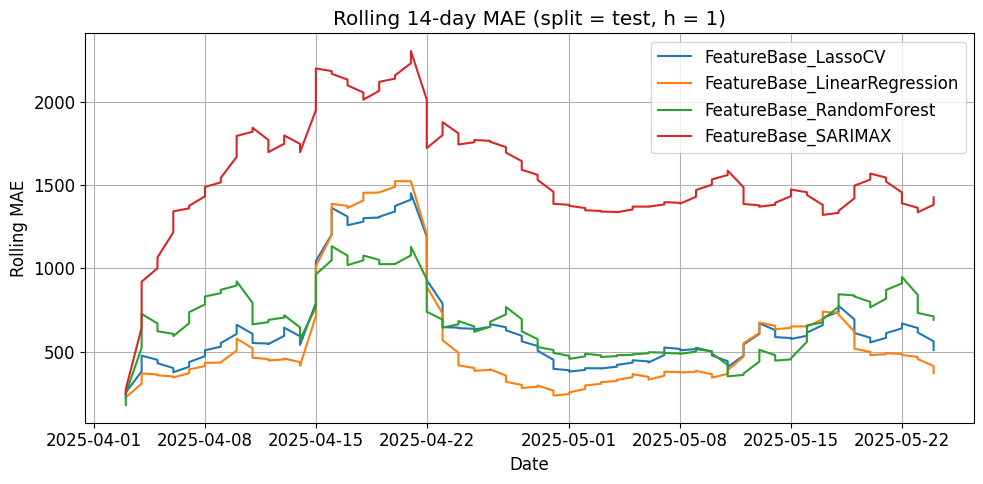

In [8]:
#rolling mae over time per model
#if tabtx can be run on same test split, add results to same plot

#CHANGE this to "val" to see tabtx results, "test" for baseline
SPLIT_TO_PLOT = "test"

sub = pred[pred["split"] == SPLIT_TO_PLOT].copy()
sub["abs_err"] = (sub["y_pred"] - sub["y_true"]).abs()

#CHANGE this to select which horizon to visualize (h = 1 would visualize next day)
H_TO_PLOT = 1
sub_h = sub[sub["horizon"] == H_TO_PLOT].copy()

#compute rolling mae
WINDOW = 14
plt.figure()
for m, g in sub_h.groupby("model"):
    g = g.sort_values("date")
    roll = g["abs_err"].rolling(WINDOW, min_periods = 5).mean()
    plt.plot(g["date"], roll, label = m)
plt.title(f"Rolling {WINDOW}-day MAE (split = {SPLIT_TO_PLOT}, h = {H_TO_PLOT})")
plt.xlabel("Date"); plt.ylabel("Rolling MAE"); plt.legend(); plt.tight_layout()
#saving the generated plot to OUTPUT_DIR
plt.savefig(OUTPUT_DIR / f"plot_rollingMAE_{SPLIT_TO_PLOT}_h{H_TO_PLOT}.png", dpi = 200)
plt.show()

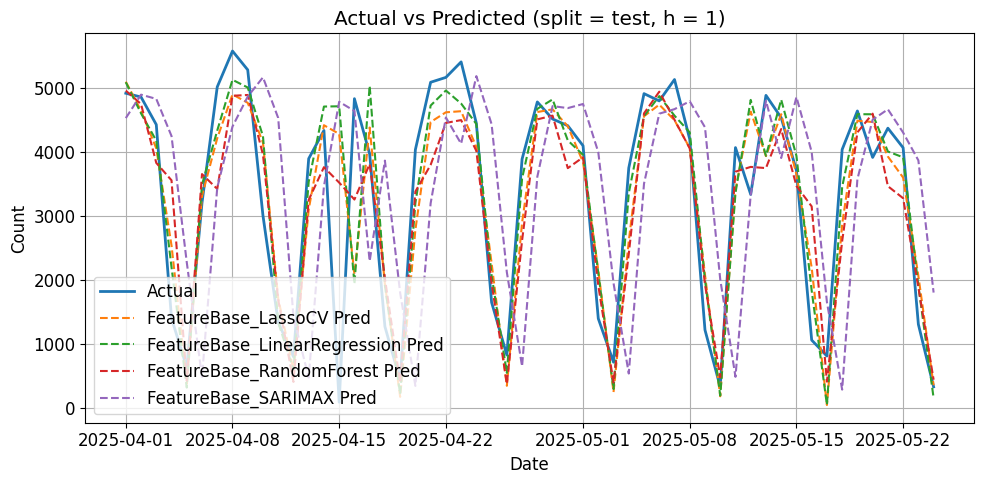

In [9]:
#actual vs predicted plot

#CHANGE this to "val" to see tabtx results, "test" for baseline
SPLIT_TO_PLOT = "test"
#CHANGE this to select which horizon to visualize (h = 1 would visualize next day)
H_TO_PLOT = 1

ts = pred[(pred["split"] == SPLIT_TO_PLOT) & (pred["horizon"] == H_TO_PLOT)].copy()

plt.figure()
for m, g in ts.groupby("model"):
    g = g.sort_values("date")
    break

#plot actual and align using any model's date
g0 = list(ts.groupby("model"))[0][1].sort_values("date")
plt.plot(g0["date"], g0["y_true"], label = "Actual", linewidth = 2)

#plot each model's preds
for m, g in ts.groupby("model"):
    g = g.sort_values("date")
    plt.plot(g["date"], g["y_pred"], label=f"{m} Pred", linestyle="--")

plt.title(f"Actual vs Predicted (split = {SPLIT_TO_PLOT}, h = {H_TO_PLOT})")
plt.xlabel("Date"); plt.ylabel("Count"); plt.legend(); plt.tight_layout()
#saving the generated plot to OUTPUT_DIR
plt.savefig(OUTPUT_DIR / f"plot_time_overlay_{SPLIT_TO_PLOT}_h{H_TO_PLOT}.png", dpi = 200)
plt.show()

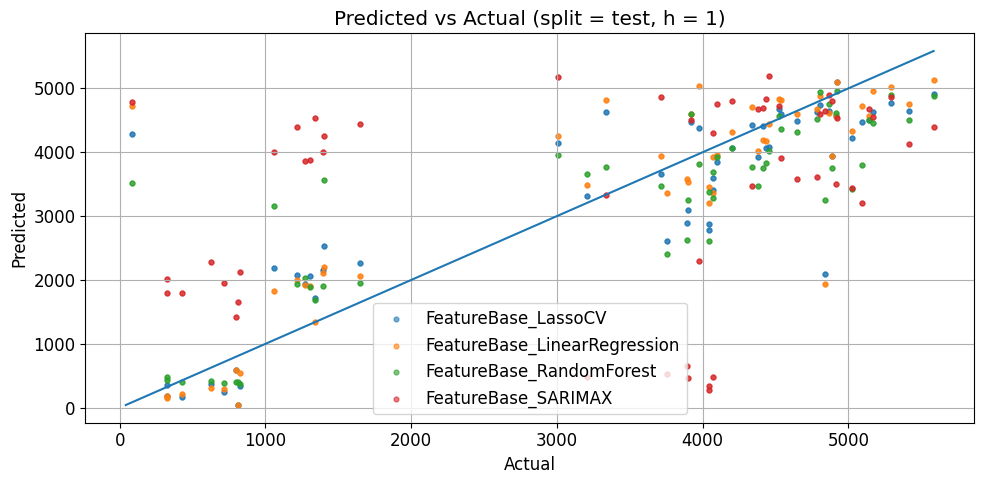

In [10]:
#predicted vs actual scatter plot

#CHANGE this to "val" to see tabtx results, "test" for baseline
SPLIT_TO_PLOT = "test"
#CHANGE this to select which horizon to visualize (h = 1 would visualize next day)
H_TO_PLOT = 1

sc = pred[(pred["split"] == SPLIT_TO_PLOT) & (pred["horizon"] == H_TO_PLOT)].copy()

#determine shared axis limits
mins = []
maxs = []
for _, g in sc.groupby("model"):
    mins += [g["y_true"].min(), g["y_pred"].min()]
    maxs += [g["y_true"].max(), g["y_pred"].max()]
lim_min, lim_max = float(np.min(mins)), float(np.max(maxs))

plt.figure()
for m, g in sc.groupby("model"):
    plt.scatter(g["y_true"], g["y_pred"], s = 12, alpha = 0.6, label = m)
plt.plot([lim_min, lim_max], [lim_min, lim_max])
plt.title(f"Predicted vs Actual (split = {SPLIT_TO_PLOT}, h = {H_TO_PLOT})")
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.legend(); plt.tight_layout()
#saving the generated plot to OUTPUT_DIR
plt.savefig(OUTPUT_DIR / f"plot_scatter_{SPLIT_TO_PLOT}_h{H_TO_PLOT}.png", dpi = 200)
plt.show()

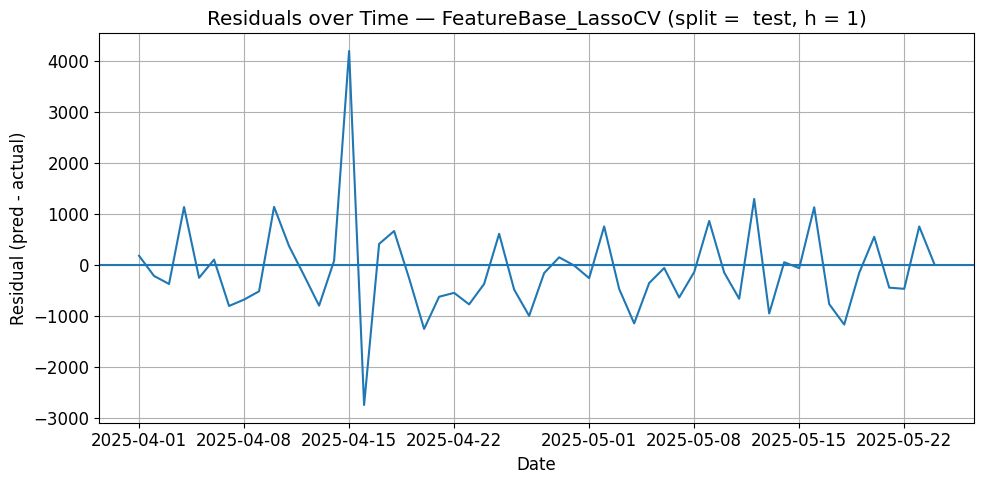

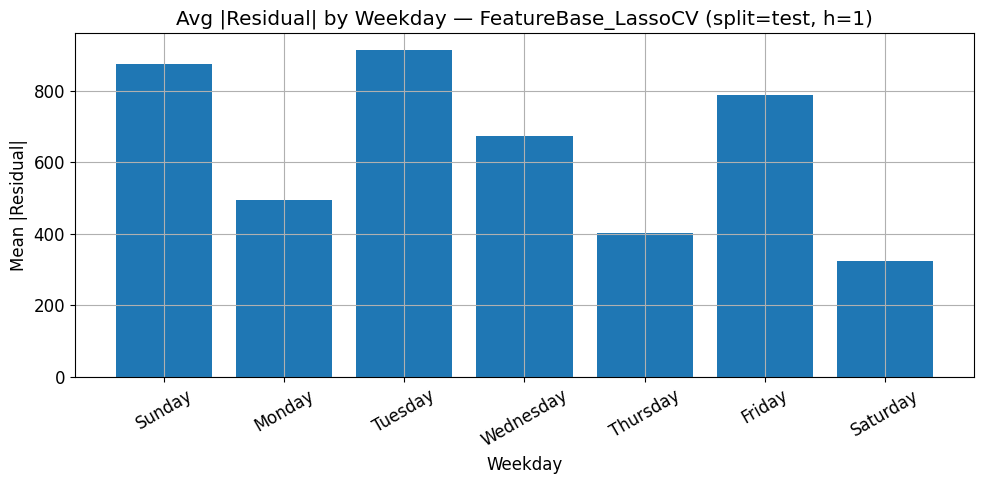

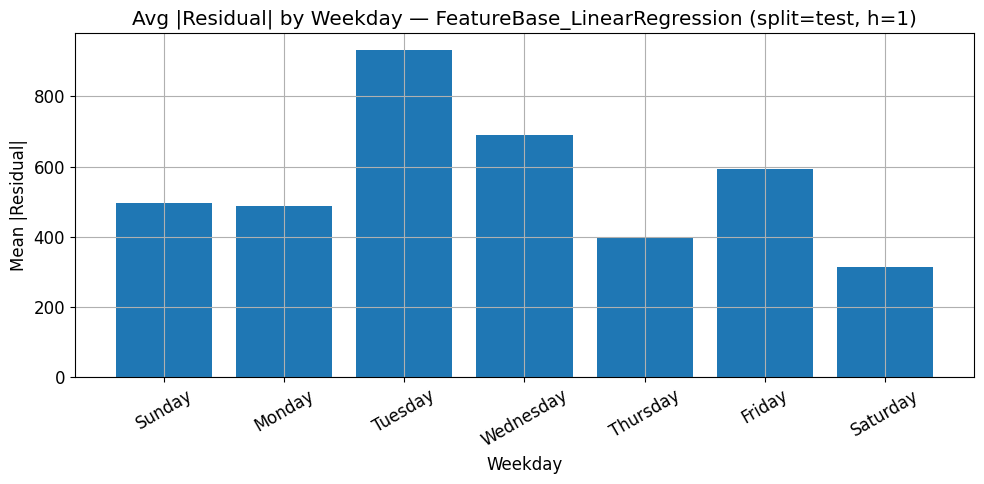

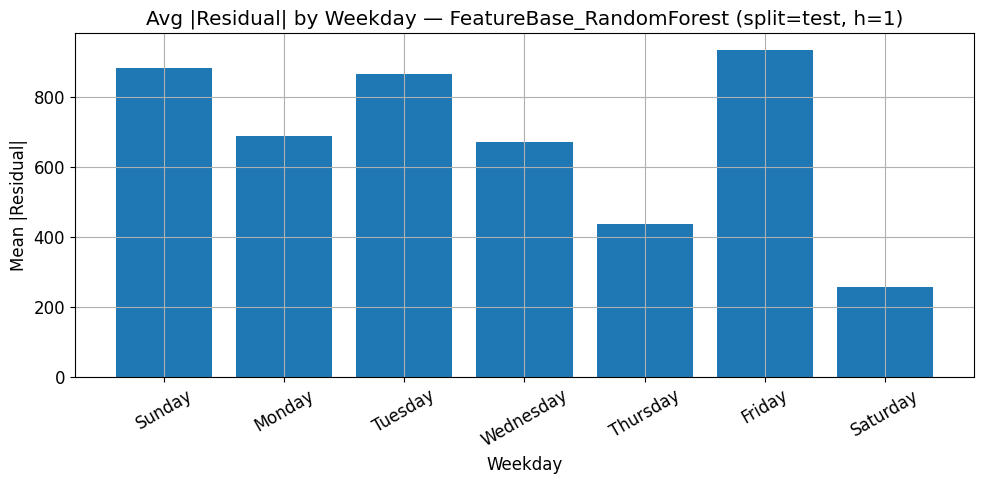

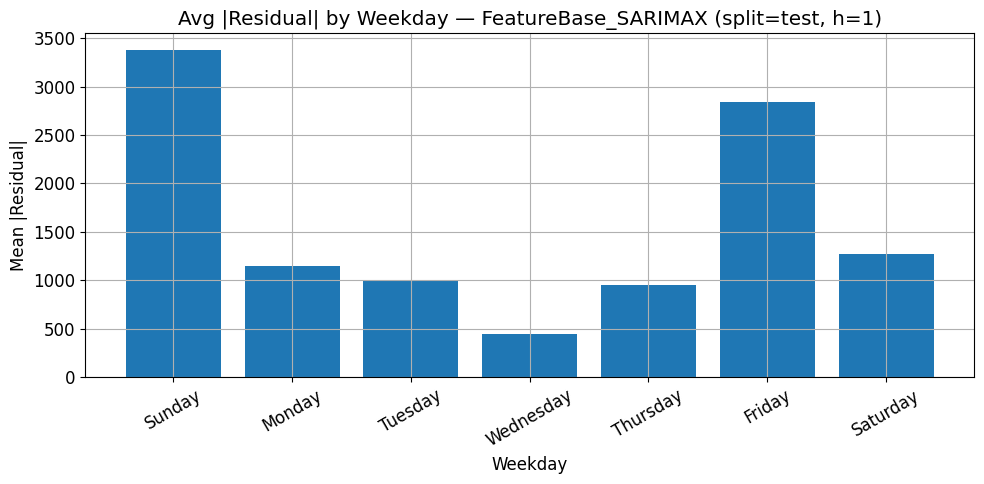

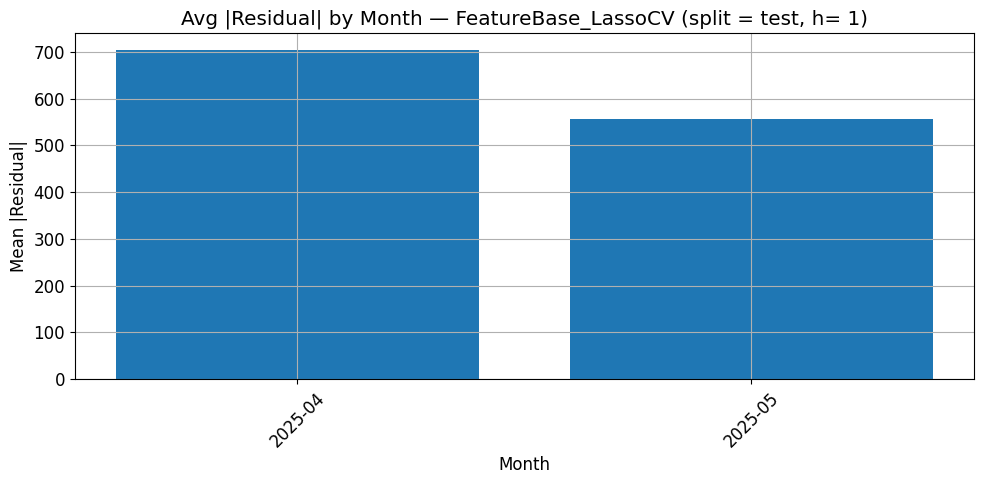

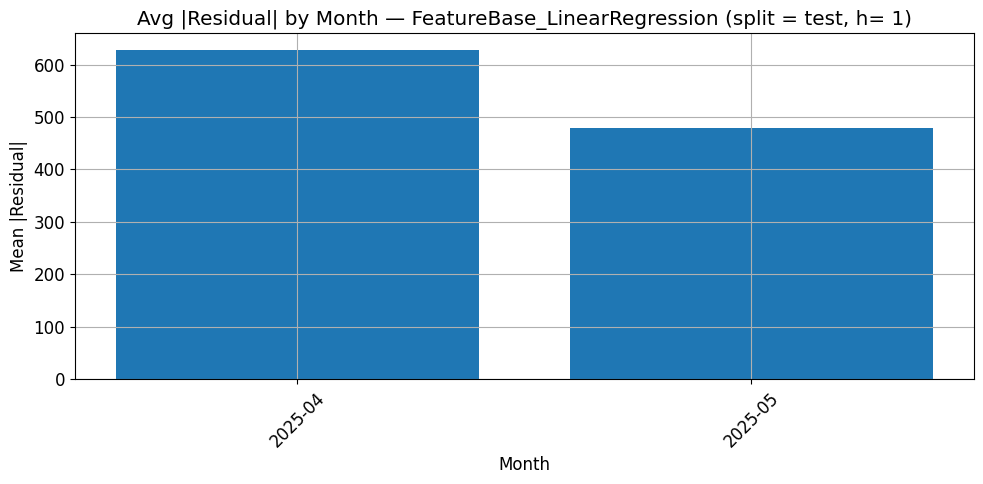

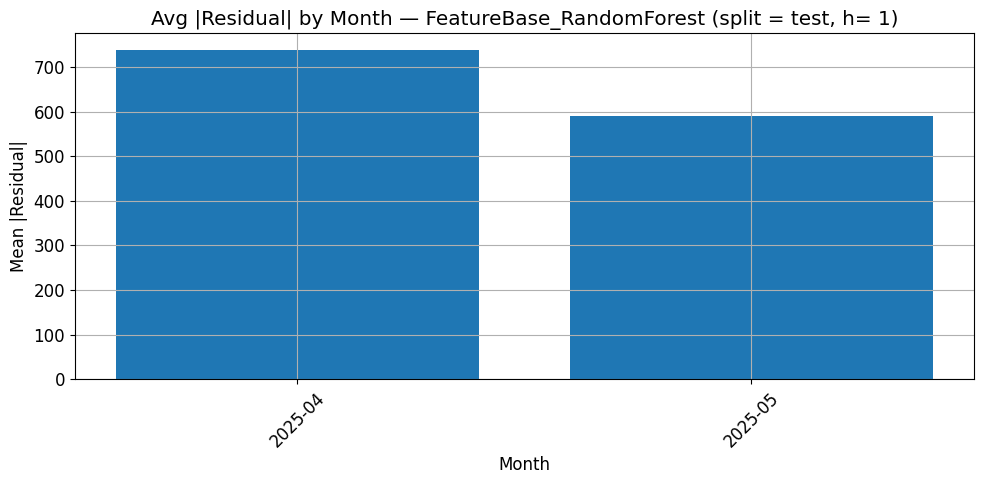

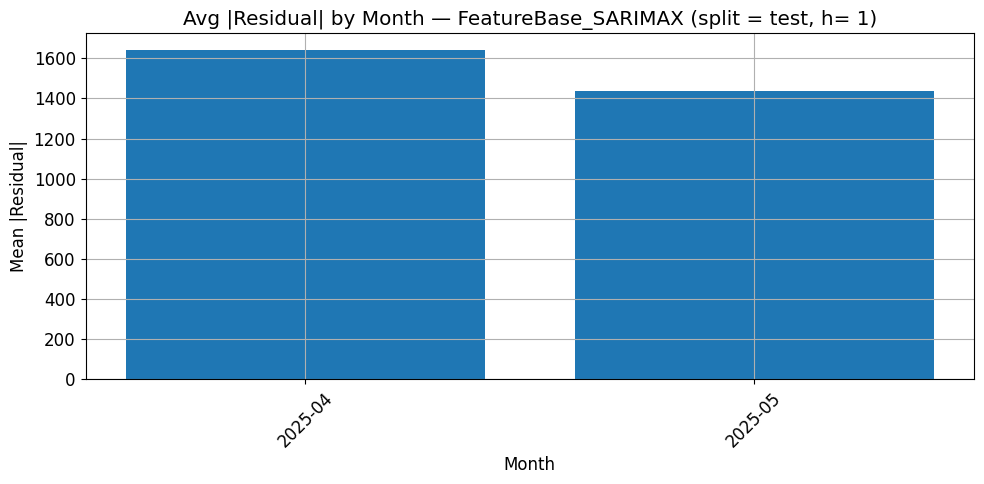

In [11]:
#residuals and error by weekday/month

#CHANGE this to "val" to see tabtx results, "test" for baseline
SPLIT_TO_ANALYZE = "test"

diag = pred[pred["split"] == SPLIT_TO_ANALYZE].copy()
diag["residual"] = diag["y_pred"] - diag["y_true"]
diag["abs_err"] = diag["residual"].abs()
diag["weekday"] = diag["date"].dt.day_name()
diag["month"] = diag["date"].dt.to_period("M").astype(str)

#residuals over time
M_TO_PLOT = diag["model"].unique()[0]
#CHANGE this to select which horizon to visualize (h = 1 would visualize next day)
H_TO_PLOT = 1
g = diag[(diag["model"] == M_TO_PLOT) & (diag["horizon"] == H_TO_PLOT)].sort_values("date")

plt.figure()
plt.plot(g["date"], g["residual"])
plt.axhline(0)
plt.title(f"Residuals over Time — {M_TO_PLOT} (split =  {SPLIT_TO_ANALYZE}, h = {H_TO_PLOT})")
plt.xlabel("Date"); plt.ylabel("Residual (pred - actual)"); plt.tight_layout()
#saving the generated plot to OUTPUT_DIR
plt.savefig(OUTPUT_DIR / f"plot_residuals_{M_TO_PLOT}_{SPLIT_TO_ANALYZE}_h{H_TO_PLOT}.png", dpi = 200)
plt.show()

#error by day of the week
wk = (diag.groupby(["model","horizon","weekday"])["abs_err"].mean().rename("MAE_like").reset_index())
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
wk["weekday"] = pd.Categorical(wk["weekday"], categories = order, ordered = True)
wk = wk.sort_values(["model","horizon","weekday"])
#CHANGE this to select which horizon to visualize (h = 1 would visualize next day)
H_TO_PLOT = 1
wk_h = wk[wk["horizon"] == H_TO_PLOT]
for m in wk_h["model"].unique():
    plt.figure()
    tmp = wk_h[wk_h["model"] == m]
    plt.bar(tmp["weekday"].astype(str), tmp["MAE_like"])
    plt.title(f"Avg |Residual| by Weekday — {m} (split={SPLIT_TO_ANALYZE}, h={H_TO_PLOT})")
    plt.xlabel("Weekday"); plt.ylabel("Mean |Residual|"); plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"plot_weekday_{m}_{SPLIT_TO_ANALYZE}_h{H_TO_PLOT}.png", dpi=200)
    plt.show()

#error by month
mo = (diag.groupby(["model","horizon","month"])["abs_err"].mean().rename("MAE_like").reset_index())
#CHANGE this to select which horizon to visualize (h = 1 would visualize next day)
H_TO_PLOT = 1
mo_h = mo[mo["horizon"] == H_TO_PLOT]
for m in mo_h["model"].unique():
    plt.figure()
    tmp = mo_h[mo_h["model"] == m]
    plt.bar(tmp["month"], tmp["MAE_like"])
    plt.title(f"Avg |Residual| by Month — {m} (split = {SPLIT_TO_ANALYZE}, h= {H_TO_PLOT})")
    plt.xlabel("Month"); plt.ylabel("Mean |Residual|"); plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"plot_month_{m}_{SPLIT_TO_ANALYZE}_h{H_TO_PLOT}.png", dpi = 200)
    plt.show()

#saving generated plots to OUTPUT_DIR
wk.to_csv(OUTPUT_DIR / f"metrics_segment_weekday_{SPLIT_TO_ANALYZE}.csv", index = False)
mo.to_csv(OUTPUT_DIR / f"metrics_segment_month_{SPLIT_TO_ANALYZE}.csv", index = False)

In [12]:
#bootstrap confidence intervals for MAE/RMSE
rng = np.random.default_rng(42)

def bootstrap_ci(y, p, fn, n_boot = 1000, alpha = 0.05):
    y = np.asarray(y, float); p = np.asarray(p, float)
    n = len(y)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        stats.append(fn(y[idx], p[idx]))
    lo = np.quantile(stats, alpha/2)
    hi = np.quantile(stats, 1 - alpha/2)
    return lo, hi

rows = []
for (split, model, horizon), g in pred.groupby(["split","model","horizon"]):
    lo_mae, hi_mae = bootstrap_ci(g["y_true"].values, g["y_pred"].values, mae)
    lo_rmse, hi_rmse = bootstrap_ci(g["y_true"].values, g["y_pred"].values, rmse)
    rows.append({
        "split": split, "model": model, "horizon": horizon,
        "MAE": mae(g["y_true"], g["y_pred"]), "MAE_lo": lo_mae, "MAE_hi": hi_mae,
        "RMSE": rmse(g["y_true"], g["y_pred"]), "RMSE_lo": lo_rmse, "RMSE_hi": hi_rmse,
        "n": len(g)
    })
ci_df = pd.DataFrame(rows).sort_values(["split","horizon","RMSE"])
display(ci_df.head(20))
#saving generated plots to OUTPUT_DIR
ci_df.to_csv(OUTPUT_DIR / "metrics_bootstrap_ci.csv", index=False)

,split,model,horizon,MAE,MAE_lo,MAE_hi,RMSE,RMSE_lo,RMSE_hi,n
3,test,FeatureBase_LinearRegression,1,561.722777,446.154412,702.900328,913.690395,584.548228,1217.625971,108
6,test,FeatureBase_RandomForest,1,672.696442,567.468037,791.299736,916.719755,740.726980,1103.022419,108
0,test,FeatureBase_LassoCV,1,638.058911,519.992983,772.365231,930.002046,691.654192,1185.689352,108
9,test,FeatureBase_SARIMAX,1,1551.240624,1323.474056,1760.436271,1965.285336,1742.558574,2197.954044,108
4,test,FeatureBase_LinearRegression,3,644.387412,515.876030,782.043640,953.838202,655.892570,1224.451269,108
7,test,FeatureBase_RandomForest,3,695.542459,571.244492,842.874808,1001.231341,735.669819,1264.540340,108
1,test,FeatureBase_LassoCV,3,709.532443,586.965040,853.655767,1006.348681,736.366188,1270.327638,108
10,test,FeatureBase_SARIMAX,3,1462.766386,1250.683348,1655.898341,1838.368950,1617.824502,2044.449257,108
8,test,FeatureBase_RandomForest,7,617.137958,489.057234,769.513819,966.428921,637.376369,1251.696600,108
2,test,FeatureBase_LassoCV,7,610.831712,468.378216,782.413123,1018.853570,679.813366,1307.356148,108
